In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.stats.mstats import normaltest # D'Agostino K^2 Test
from scipy.stats import boxcox

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

from sklearn.metrics import r2_score  # how well we are explaining our variants wrt regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## **Model Tracking**

In [75]:
log_df = pd.DataFrame(columns = ['modelName', 'features_list', 'features_size', 'hyperparameters', 'scaling_type', 'no_of_kfolds', 'polynomial_degree','comments','r2-score', 'cohen_kappa_score'])

In [76]:
class Logger_Regression:
    modelName = "",      # linearRegression,lasso,ridge, SVR 
    features_list = list(),
    features_size = 0,
    hyperparameters = "none",  #aplha_value, max_iteration
    scaling_type = "none",    #standard, minmax, maxabs
    no_of_kfolds = 0,
    polynomial_degree = 1,  #default linear regression
    comments = "",
    r2_score = 0,
    cohen_kappa_score = 0

    def  __init__(self, modelName, feature_list, features_size):
      self.modelName = modelName
      self.features_list = feature_list
      self.features_size = features_size

    def linearRegression_basic(self,X,y):
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=72018)
      lr = LinearRegression()
      lr.fit(X_train, y_train)
      y_pred = lr.predict(X_test)
      self.r2_score = r2_score(y_test,y_pred)*100
      self.add_log()
      #return (r2_score(y_test,y_pred))

    def linearRegression_scaling(self,X,y,no_of_kfolds):
      kf = KFold(shuffle=True, random_state=72018, n_splits=no_of_kfolds)
      self.no_of_kfolds = no_of_kfolds
      scalers = {'standard': StandardScaler(),
                  'minmax': MinMaxScaler(),
                  'maxabs': MaxAbsScaler()}
      # for train_index, test_index in kf.split(X):
      #   X_train, X_test, y_train, y_test = (X.iloc[train_index, :], 
      #                                       X.iloc[test_index, :], 
      #                                       y[train_index], 
      #                                       y[test_index])
        
      for scaler_label, scaler in scalers.items():
         s = scaler
         self.scaling_type = scaler_label
         lr = LinearRegression()
         estimator = Pipeline([("scaler", s), ("regression", lr)])
         predictions = cross_val_predict(estimator, X, y, cv=kf)
         self.r2_score = r2_score(y, predictions)*100
         self.add_log()

    def set_comment(self,message):
      self.comments = message
    
    def add_log(self):
      row = [self.modelName, self.features_list, self.features_size, self.hyperparameters, self.scaling_type, self.no_of_kfolds, self.polynomial_degree, self.comments ,self.r2_score, self.cohen_kappa_score]
      log_df.loc[len(log_df)] = row

## **Approach01: Traditional Features**

### **Transforming Target**
1. Log Test
2. Square Root
3. Box Cox

Apply transformations to make target variable more normally distributed for regression.

In [45]:
from google.colab import drive
drive.mount('/content/drive')
df_train = pd.read_csv("/content/drive/My Drive/IntelliTech-DataSet/EssaySet01_Features.csv", index_col =0)
df_train.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Sent_Count,Word_Count,Char_Count,Avg_Word_Count,Verb_Count,Noun_Count,Adj_Count,Conj_Count,Adverb_Count,pNoun_Count,...,Punctuation_Errors,Connectivity_Index,Semantic_Similarity,Flesch_Reading_Ease_Score,Flesh_Kincaid_Grade,Dale_Challl_Readability_Score,Lexical_Diversity,Lexical_Density,Lexical_Originality,Total Score
0,16,386,1875,3.984456,55,74,18,14,15,48,...,1,24.552787,0.396690,86.789576,5.484289,6.551183,0.370466,224,0.000192,8
1,20,464,2288,4.030172,71,97,19,18,19,49,...,6,25.344232,0.311087,79.907259,5.122937,6.726940,0.342672,273,0.000214,9
2,14,313,1541,4.035144,42,69,17,16,11,25,...,4,14.662850,0.291317,80.081797,4.728247,7.015542,0.418530,180,0.000176,7
3,27,611,3165,4.328969,71,126,39,17,21,33,...,2,32.408323,0.269810,84.865926,4.821414,7.214003,0.301146,306,0.000247,10
4,30,517,2569,4.071567,61,107,30,15,34,41,...,2,27.824804,0.264052,81.834076,2.236540,6.354310,0.324952,288,0.000226,8


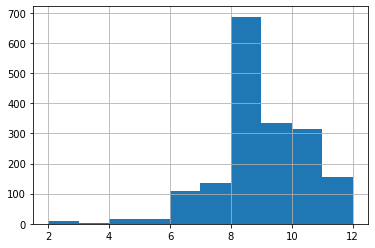

In [46]:
df_train['Total Score'].hist()

In [47]:
#This test outputs a "p-value". The higher this p-value is the closer the distribution is to normal.
#If the p-value > 0.05, then it is bell-curve distribution.
#Our data is clearly right skewed (Histogram)
normaltest(df_train['Total Score'].values)  

NormaltestResult(statistic=127.21536231858303, pvalue=2.3742971207847717e-28)

In [48]:
df_train['Total Score'].describe()

count    1783.000000
mean        8.528323
std         1.538565
min         2.000000
25%         8.000000
50%         8.000000
75%        10.000000
max        12.000000
Name: Total Score, dtype: float64

#### Transforming Target Through Log Test

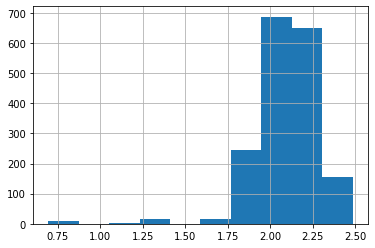

In [49]:
log_scores = np.log(df_train['Total Score'])
log_scores.hist();

In [50]:
log_scores

0       2.079442
1       2.197225
2       1.945910
3       2.302585
4       2.079442
          ...   
1778    2.079442
1779    1.945910
1780    2.079442
1781    0.693147
1782    1.945910
Name: Total Score, Length: 1783, dtype: float64

In [51]:
normaltest(log_scores)   # No significant change in p-value

NormaltestResult(statistic=967.974762708955, pvalue=6.411371863279588e-211)

Transforming Through Square Root Transformation

(array([ 10.,   1.,  17.,   0.,  17., 110., 822., 334., 316., 156.]),
 array([1.41421356, 1.61920237, 1.82419117, 2.02917998, 2.23416878,
        2.43915759, 2.64414639, 2.8491352 , 3.054124  , 3.25911281,
        3.46410162]),
 <a list of 10 Patch objects>)

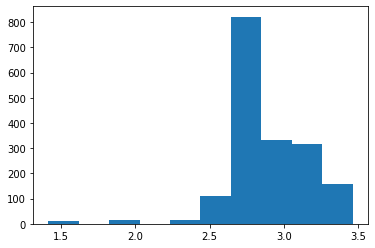

In [52]:
sqrt_scores = np.sqrt(df_train['Total Score'])
plt.hist(sqrt_scores)

In [53]:
normaltest(sqrt_scores)

NormaltestResult(statistic=456.280616698139, pvalue=8.316162831695822e-100)

Target Transformation Through BoxCox



In [54]:
bc_result = boxcox(df_train['Total Score'])
boxcox_score = bc_result[0]
lam = bc_result[1]
lam

1.5655301603375742

In [55]:
boxcox_score.shape

(1783,)

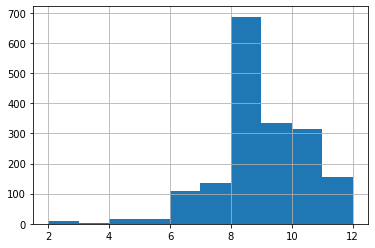

In [56]:
df_train['Total Score'].hist();

In [57]:
normaltest(boxcox_score)

NormaltestResult(statistic=17.904988785940628, pvalue=0.00012941394786243168)

Significantly more normally distributed (according to p value) than the other two distributions

### **Linear Regression Model**


In [77]:
#basic model
y_col = "Total Score"
X = df_train.drop(y_col, axis=1)
y = df_train[y_col]
data_logger = Logger_Regression("Linear Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Vanilla Linear Regression Model")
data_logger.linearRegression_basic(X,y)

#boxcox variation
data_logger = Logger_Regression("Linear Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Vanilla Linear Regression Model with Boxcox variation")
data_logger.linearRegression_basic(X,boxcox_score)


In [78]:
#scaling with no transformation
data_logger = Logger_Regression("Linear Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Vanilla Linear Regression Model with Scaling")
data_logger.linearRegression_scaling(X,y,3)

#scaling with target transformation
data_logger = Logger_Regression("Linear Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Vanilla Linear Regression Model with Scaling")
data_logger.linearRegression_scaling(X,boxcox_score,3)

In [79]:
log_df.head()

,modelName,features_list,features_size,hyperparameters,scaling_type,no_of_kfolds,polynomial_degree,comments,r2-score,cohen_kappa_score
0,Linear Regression,"[Sent_Count, Word_Count, Char_Count, Avg_Word_...",26,"(none,)","(none,)","(0,)","(1,)",Vanilla Linear Regression Model,73.633025,0
1,Linear Regression,"[Sent_Count, Word_Count, Char_Count, Avg_Word_...",26,"(none,)","(none,)","(0,)","(1,)",Vanilla Linear Regression Model with Boxcox va...,72.176556,0
2,Linear Regression,"[Sent_Count, Word_Count, Char_Count, Avg_Word_...",26,"(none,)",standard,3,"(1,)",Vanilla Linear Regression Model with Scaling,73.984812,0
3,Linear Regression,"[Sent_Count, Word_Count, Char_Count, Avg_Word_...",26,"(none,)",minmax,3,"(1,)",Vanilla Linear Regression Model with Scaling,73.984812,0
4,Linear Regression,"[Sent_Count, Word_Count, Char_Count, Avg_Word_...",26,"(none,)",maxabs,3,"(1,)",Vanilla Linear Regression Model with Scaling,73.984812,0


In [80]:
log_df['r2-score'].head(10)

0    73.633025
1    72.176556
2    73.984812
3    73.984812
4    73.984812
5    72.091003
6    72.091003
7    72.091003
Name: r2-score, dtype: float64

### **Word2Vec Features**

In [62]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/IntelliTech-DataSet/EssaySet01.csv")
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,ID,Essay,Rater_1 Score,Rater_2 Score,Total Score
0,1,"Dear local newspaper, I think effects computer...",4.0,4.0,8.0
1,2,"Dear @CAPS1 @CAPS2, I believe that using compu...",5.0,4.0,9.0
2,3,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4.0,3.0,7.0
3,4,"Dear Local Newspaper, @CAPS1 I have found that...",5.0,5.0,10.0
4,5,"Dear @LOCATION1, I know having computers has a...",4.0,4.0,8.0


In [63]:
essays = df['Essay']
essays.shape

(1783,)

In [64]:
# create a list of essay strings
essay_list = [ess for ess in essays]

# tokenize the string into words
tokens = [word_tokenize(ess) for ess in essay_list]

# Remove non-alphabetic tokens, such as punctuation
words_list = [[word.lower() for word in sentences if word.isalpha()] for sentences in tokens]

# Remove stopwords
words_list = [[word for word in sentence if not word in stop_words] for sentence in words_list]


In [65]:
def word2vec_model(docs_list):
  model = Word2Vec(docs_list, min_count=1)

  # understanding the model
  # print("Dimension of Word Vectors are: ", model.vector_size)
  # word embedding vector for a specific token 'dear'
  #print(model.wv['dear'])

  vocab = list(model.wv.vocab.keys())
  df = pd.DataFrame([model.wv.word_vec(w) for w in vocab], index=vocab)
  print(df.shape)
  df.to_csv("word2vec_features.csv", index = True)

word2vec_model(words_list)

(15342, 100)
